## Setting up the Environment

In [3]:
! pip install transformers datasets librosa torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


## Load the dataset

In [4]:
from datasets import load_dataset

# Load the Speech Commands Dataset
speech_commands = load_dataset("speech_commands", 'v0.01', split="test", trust_remote_code=True)

# Display the first example
print(speech_commands[0])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/12.1k [00:00<?, ?B/s]

speech_commands.py:   0%|          | 0.00/7.31k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/51093 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6799 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3081 [00:00<?, ? examples/s]

{'file': 'bed/6205088b_nohash_2.wav', 'audio': {'path': 'bed/6205088b_nohash_2.wav', 'array': array([-0.06311035, -0.06402588, -0.06454468, ..., -0.06488037,
       -0.0647583 , -0.06494141]), 'sampling_rate': 16000}, 'label': 20, 'is_unknown': True, 'speaker_id': '6205088b', 'utterance_id': 2}


In [5]:
speech_commands

Dataset({
    features: ['file', 'audio', 'label', 'is_unknown', 'speaker_id', 'utterance_id'],
    num_rows: 3081
})

In [4]:
from collections import Counter
Counter(speech_commands["label"])

Counter({20: 1340,
         21: 1411,
         22: 1399,
         23: 1396,
         3: 1842,
         18: 1852,
         15: 1844,
         14: 1839,
         9: 1861,
         24: 1373,
         25: 1427,
         4: 1839,
         26: 1424,
         19: 1875,
         1: 1853,
         7: 1839,
         6: 1864,
         11: 1892,
         5: 1852,
         17: 1875,
         27: 1372,
         30: 5,
         16: 1863,
         8: 1885,
         13: 1841,
         28: 1374,
         12: 1873,
         2: 1843,
         29: 1414,
         0: 1860,
         10: 1866})

## Essential Preprocessing Steps:
1- Resampling:
  Ensure all audio files have the same sampling rate. Many models expect audio at 16 kHz.

2- Normalization:
  Normalize the audio signal to ensure consistent amplitude values across all samples.

3- Padding or Truncation:
  Audio samples should have the same length (e.g., 1 second for Speech Commands). Shorter audio can be padded with zeros; longer ones can be truncated.

4- Feature Extraction:
  Convert raw waveforms into features that models can process:
    Mel Spectrograms: Represent audio in the frequency domain.
    

5- Label Encoding:
  Convert textual labels (e.g., "yes", "no") into numeric indices that models can use.


#### 1- resampling

In [7]:

audio_sample = speech_commands[0]

print(f"Sampling rate: {audio_sample['audio']['sampling_rate']} Hz") # So no need to resampling

Sampling rate: 16000 Hz


#### 2- Normalize

In [8]:
import numpy as np

def normalize(audio_sample):
    waveform = audio_sample["audio"]["array"]

    # Normalize the waveform
    normalized_waveform = waveform / np.max(np.abs(waveform))

    # Update the sample with the normalized waveform
    audio_sample["audio"]["array"] = normalized_waveform

    return audio_sample


In [9]:
normalized_speech_commands = speech_commands.map(normalize)

Map:   0%|          | 0/3081 [00:00<?, ? examples/s]

In [10]:
#Check a normalized waveform

print("before normalized waveform for the first sample:")
print(speech_commands[0]["audio"]["array"][:10])

print("Normalized waveform for the first sample:")
print(normalized_speech_commands[0]["audio"]["array"][:10])

before normalized waveform for the first sample:
[-0.06311035 -0.06402588 -0.06454468 -0.0637207  -0.06530762 -0.0663147
 -0.0647583  -0.0647583  -0.06341553 -0.06256104]
Normalized waveform for the first sample:
[-0.19180298 -0.1946106  -0.19616699 -0.19366455 -0.19848633 -0.2015686
 -0.19683838 -0.19683838 -0.19274902 -0.19015503]


In [11]:
normalized_speech_commands.save_to_disk("normalized_speech_commands")


Saving the dataset (0/1 shards):   0%|          | 0/3081 [00:00<?, ? examples/s]

#### 3- Padding or Truncation

In [12]:
# min, max length in audio data
def calculate_duration(sample):
    sampling_rate = sample["audio"]["sampling_rate"]
    duration = len(sample["audio"]["array"]) / sampling_rate
    return {"duration": duration}

# Calculate duration for each sample
duration_speech_commands = speech_commands.map(calculate_duration)


Map:   0%|          | 0/3081 [00:00<?, ? examples/s]

In [13]:

# Find the minimum and maximum durations
min_duration = min(duration_speech_commands["duration"])
max_duration = max(duration_speech_commands["duration"])

print(f"Minimum duration: {min_duration} seconds")
print(f"Maximum duration: {max_duration} seconds")

Minimum duration: 1.0 seconds
Maximum duration: 1.0 seconds


S0 we need to make padding and truncation to our audio


In [14]:
# Target duration in seconds
target_duration = 1.0
sampling_rate = 16000

In [15]:
def pad_or_truncate_audio(sample):
    wafveform = sample["audio"]["array"]
    target_length = int(target_duration * sampling_rate)

    # Padding
    if len(wafveform) < target_length:
        padding = (target_length - len(wafveform))
        wafveform = np.pad(wafveform, (0, padding), mode='constant')

    # Truncation
    elif len(wafveform) > target_length:
        wafveform = wafveform[:target_length]

    sample["audio"]["array"] = wafveform
    return sample


In [16]:
standardized_dataset = duration_speech_commands.map(pad_or_truncate_audio)


Map:   0%|          | 0/3081 [00:00<?, ? examples/s]

#### 5- Encoding
the labels are integers, there is no need for further encoding.

In [47]:
type(standardized_dataset[0]["label"])

int

In [48]:
print(standardized_dataset.features["label"])

ClassLabel(names=['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'bed', 'bird', 'cat', 'dog', 'happy', 'house', 'marvin', 'sheila', 'tree', 'wow', '_silence_'], id=None)


## Models training setup

##### 2- Models


1.   Audio Spectrogram Transformer (AST)
2.   HuBERT





In [24]:
# Define metrics
def compute_metrics(pred):
    predictions = np.argmax(pred.predictions, axis=1)
    labels = pred.label_ids
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted")
    accuracy = accuracy_score(labels, predictions)
    return {
        "accuracy": accuracy,
        "f1": f1,
        "precision": precision,
        "recall": recall,
    }


#### 1- AST

###### Feature Extraction





In [6]:
import librosa

def extract_mel_spectrogram(audio_sample, sampling_rate = 16000, n_mels = 128):
    waveform = audio_sample["audio"]["array"]

    mel_spectrogram = librosa.feature.melspectrogram(
        y=waveform,
        sr=sampling_rate,
        n_mels=n_mels
        )
    audio_sample["mel_spectrogram"] = mel_spectrogram
    return audio_sample

In [17]:
mel_dataset = standardized_dataset.map(extract_mel_spectrogram)

Map:   0%|          | 0/3081 [00:00<?, ? examples/s]

##### Data split

In [19]:
# split data
mel_dataset = mel_dataset.train_test_split(test_size=0.2, seed=42)
mel_dataset

DatasetDict({
    train: Dataset({
        features: ['file', 'audio', 'label', 'is_unknown', 'speaker_id', 'utterance_id', 'duration', 'mel_spectrogram'],
        num_rows: 2464
    })
    test: Dataset({
        features: ['file', 'audio', 'label', 'is_unknown', 'speaker_id', 'utterance_id', 'duration', 'mel_spectrogram'],
        num_rows: 617
    })
})

In [20]:

# Further split the test set into validation (10%) and test (10%)
test_validation = mel_dataset["test"].train_test_split(test_size=0.5, seed=42)


##### Train


In [22]:
from transformers import ASTForAudioClassification, ASTFeatureExtractor

# Load AST model and feature extractor
ast_model = ASTForAudioClassification.from_pretrained("MIT/ast-finetuned-speech-commands-v2")
ast_feature_extractor = ASTFeatureExtractor.from_pretrained("MIT/ast-finetuned-speech-commands-v2")

# Example: Prepare a sample for AST
example_audio = mel_dataset["train"][0]["audio"]["array"]
features_ast = ast_feature_extractor(example_audio, sampling_rate=16000, return_tensors="pt")

print("AST Input Shape:", features_ast.input_values.shape)


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

config.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/342M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/295 [00:00<?, ?B/s]

AST Input Shape: torch.Size([1, 128, 128])


In [23]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import TrainingArguments, Trainer

In [26]:
# Preprocess the dataset for AST
def preprocess_ast(sample):
    features = ast_feature_extractor(
        sample["audio"]["array"], sampling_rate=16000, return_tensors="pt", padding=True
    )
    sample["input_values"] = features.input_values[0].numpy()
    return sample

# Apply preprocessing
ast_dataset_train = mel_dataset["train"].map(preprocess_ast, remove_columns=["audio"])

Map:   0%|          | 0/2464 [00:00<?, ? examples/s]

In [27]:
ast_dataset_test = mel_dataset["test"].map(preprocess_ast, remove_columns=["audio"])


Map:   0%|          | 0/617 [00:00<?, ? examples/s]

In [32]:
# split ast_dataset_test to test and validation
test_validation = ast_dataset_test.train_test_split(test_size=0.5, seed=42)

In [33]:
test_validation["test"]

Dataset({
    features: ['file', 'label', 'is_unknown', 'speaker_id', 'utterance_id', 'duration', 'mel_spectrogram', 'input_values'],
    num_rows: 309
})

In [34]:
ast_dataset_test

Dataset({
    features: ['file', 'label', 'is_unknown', 'speaker_id', 'utterance_id', 'duration', 'mel_spectrogram', 'input_values'],
    num_rows: 617
})

In [25]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [35]:
# AST Trainer
ast_trainer = Trainer(
    model=ast_model,
    args=training_args,
    train_dataset=ast_dataset_train,
    eval_dataset=test_validation["test"],
    tokenizer=ast_feature_extractor,
    compute_metrics=compute_metrics,
)

# Train AST
print("Training AST...")
ast_trainer.train()



<ipython-input-35-a8c89762a46e>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  ast_trainer = Trainer(


Training AST...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.007300,0.094885,0.970874,0.970744,0.972959,0.970874
2,0.000100,0.093120,0.967638,0.969896,0.975811,0.967638
3,0.000000,0.092457,0.970874,0.972610,0.976927,0.970874


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=924, training_loss=0.020630318413814127, metrics={'train_runtime': 315.1679, 'train_samples_per_second': 23.454, 'train_steps_per_second': 2.932, 'total_flos': 6.205375802297549e+16, 'train_loss': 0.020630318413814127, 'epoch': 3.0})

##### Evaluate

In [36]:
# Evaluate AST
print("Evaluating AST...")

ast_results = ast_trainer.evaluate(test_validation["train"])
print("AST Test Results:", ast_results)

Evaluating AST...


AST Test Results: {'eval_loss': 0.12964044511318207, 'eval_accuracy': 0.9805194805194806, 'eval_f1': 0.9804672524119505, 'eval_precision': 0.9808293014175367, 'eval_recall': 0.9805194805194806, 'eval_runtime': 5.6256, 'eval_samples_per_second': 54.75, 'eval_steps_per_second': 6.933, 'epoch': 3.0}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### 2- HuBERT

##### split data

In [53]:
# split standardized_dataset train, test
hubert_dataset = standardized_dataset.train_test_split(test_size=0.2, seed=42)

###### Train

In [51]:
from transformers import HubertForSequenceClassification, Wav2Vec2FeatureExtractor

# Load HuBERT feature extractor
hubert_feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/hubert-large-ls960-ft")

# Example: Prepare a sample for HuBERT
features_hubert = hubert_feature_extractor(standardized_dataset[0]["audio"]["array"], sampling_rate=16000, return_tensors="pt")
print("HuBERT Input Shape:", features_hubert.input_values.shape)


HuBERT Input Shape: torch.Size([1, 16000])


In [63]:

# Preprocess the dataset for HuBERT
def preprocess_hubert(sample):
    features = hubert_feature_extractor(
        sample["audio"]["array"], sampling_rate=16000, return_tensors="pt", padding=True
    )
    sample["input_values"] = features.input_values[0].numpy()
    return sample

# Apply preprocessing
hubert_dataset_tain = hubert_dataset["train"].map(preprocess_hubert, remove_columns=["audio"])

hubert_dataset_tset = hubert_dataset["test"].map(preprocess_hubert, remove_columns=["audio"])

test_validation = hubert_dataset_tset.train_test_split(test_size=0.5, seed=42)

In [64]:
from transformers import HubertForSequenceClassification

# Load the pre-trained HuBERT model
hubert_model = HubertForSequenceClassification.from_pretrained(
    "facebook/hubert-large-ls960-ft",
    num_labels=len(hubert_dataset["train"].features["label"].names),  # Set the number of labels
    id2label={i: label for i, label in enumerate(hubert_dataset["train"].features["label"].names)},
    label2id={label: i for i, label in enumerate(mel_dataset["train"].features["label"].names)},
)

Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at facebook/hubert-large-ls960-ft and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [65]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./hubert_results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    weight_decay=0.01,
    fp16=True,  # Mixed precision for faster training
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [67]:
from transformers import Trainer

# Define the Trainer
hubert_trainer = Trainer(
    model=hubert_model,
    args=training_args,
    train_dataset=hubert_dataset_tain,
    eval_dataset=test_validation["test"],
    tokenizer=hubert_feature_extractor,
    compute_metrics=compute_metrics,  # Custom metrics function
)

# Train the model
print("Fine-tuning HuBERT...")
hubert_trainer.train()


<ipython-input-67-b48853d2f88a>:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  hubert_trainer = Trainer(


Fine-tuning HuBERT...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.094300,1.790464,0.844660,0.804679,0.780401,0.844660
2,1.585600,1.179525,0.867314,0.829318,0.803497,0.867314
3,1.544600,1.031555,0.886731,0.857202,0.834276,0.886731


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=924, training_loss=1.8733617939474263, metrics={'train_runtime': 485.6758, 'train_samples_per_second': 15.22, 'train_steps_per_second': 1.903, 'total_flos': 2.24037270825984e+17, 'train_loss': 1.8733617939474263, 'epoch': 3.0})

##### Evaluate

In [68]:
# Evaluate the model
print("Evaluating HuBERT...")
hubert_results = hubert_trainer.evaluate(test_validation["train"])
print("HuBERT Test Results:", hubert_results)


Evaluating HuBERT...


HuBERT Test Results: {'eval_loss': 0.9912446141242981, 'eval_accuracy': 0.8831168831168831, 'eval_f1': 0.8570311188064047, 'eval_precision': 0.8446692097268134, 'eval_recall': 0.8831168831168831, 'eval_runtime': 4.4158, 'eval_samples_per_second': 69.75, 'eval_steps_per_second': 8.832, 'epoch': 3.0}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [96]:
# Summarize Results
print("Model Performance Comparison:")
print("AST Results:", ast_results)
print("HuBERT Results:", hubert_results)


Model Performance Comparison:
AST Results: {'eval_loss': 0.12964044511318207, 'eval_accuracy': 0.9805194805194806, 'eval_f1': 0.9804672524119505, 'eval_precision': 0.9808293014175367, 'eval_recall': 0.9805194805194806, 'eval_runtime': 5.6256, 'eval_samples_per_second': 54.75, 'eval_steps_per_second': 6.933, 'epoch': 3.0}
HuBERT Results: {'eval_loss': 0.9912446141242981, 'eval_accuracy': 0.8831168831168831, 'eval_f1': 0.8570311188064047, 'eval_precision': 0.8446692097268134, 'eval_recall': 0.8831168831168831, 'eval_runtime': 4.4158, 'eval_samples_per_second': 69.75, 'eval_steps_per_second': 8.832, 'epoch': 3.0}


## Visualize Results


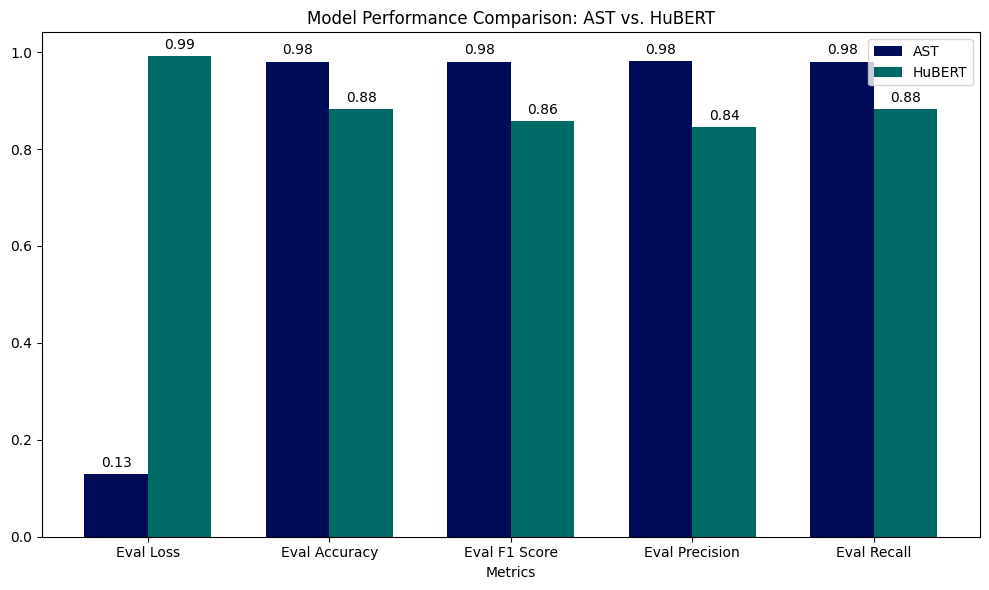

In [102]:
import matplotlib.pyplot as plt
import numpy as np

# Define the metrics for AST and HuBERT
models = ['AST', 'HuBERT']
metrics = ['Eval Loss', 'Eval Accuracy', 'Eval F1 Score', 'Eval Precision', 'Eval Recall']

ast_results = [0.1296, 0.9805, 0.9805, 0.9808, 0.9805]
hubert_results = [0.9912, 0.8831, 0.8570, 0.8447, 0.8831]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, ast_results, width, label='AST', color='#000B58')
rects2 = ax.bar(x + width/2, hubert_results, width, label='HuBERT', color='#006A67')

ax.set_xlabel('Metrics')
ax.set_title('Model Performance Comparison: AST vs. HuBERT')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Annotate bars with their values
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()
